# CQA Random Forest Prediction with Momentum-adjusted Portfolio Weights

In this code file, we have build upon the simple random forest classification scheme, by including a momentum-adjusted portfolio weights scheme.

Essentially, rather than taking equally proportional all the stocks that model predict as generating positive return, we only take long positions in the stocks that are in the top 25th Percentile rank in terms of stock liquidity.

Note: In this code scheme, liquidity refers to market cap* total trading volume.

delayed return  
84_Q data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

### import alpha library

In [2]:
# read data
data_matrix1 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_20_Q.csv")
data_matrix2 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_21_to_40_Q.csv")
data_matrix3 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_41_to_60_Q.csv")
data_matrix4 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_61_to_84_Q.csv")

In [3]:
data_matrix = pd.concat([data_matrix1,data_matrix2,data_matrix3,data_matrix4],ignore_index=True)

### monthly return

In [4]:
monthly_returns = data_matrix[['asOfDate','tic','Return']]

In [5]:
tics = data_matrix['tic']
dates = data_matrix['asOfDate']
dates = dates.apply(lambda x: x[:7])

In [6]:
dates

0         2010-09
1         2010-09
2         2010-09
3         2010-09
4         2010-09
5         2010-09
6         2010-09
7         2010-09
8         2010-09
9         2010-09
10        2010-09
11        2010-09
12        2010-09
13        2010-09
14        2010-09
15        2010-09
16        2010-09
17        2010-09
18        2010-09
19        2010-09
20        2010-09
21        2010-09
22        2010-09
23        2010-09
24        2010-09
25        2010-09
26        2010-09
27        2010-09
28        2010-09
29        2010-09
           ...   
251970    2017-08
251971    2017-08
251972    2017-08
251973    2017-08
251974    2017-08
251975    2017-08
251976    2017-08
251977    2017-08
251978    2017-08
251979    2017-08
251980    2017-08
251981    2017-08
251982    2017-08
251983    2017-08
251984    2017-08
251985    2017-08
251986    2017-08
251987    2017-08
251988    2017-08
251989    2017-08
251990    2017-08
251991    2017-08
251992    2017-08
251993    2017-08
251994    

## 1. Data preprocess

separate dates, returns (label) and alphas (data) from data matrix

In [7]:
mask = [i for i in list(range(14,488))+list(range(498,499))]
alpha_library = data_matrix.iloc[:,mask]
alpha_library.head()

,ALPHA_77,ALPHA_267,ALPHA_505,ALPHA_572,ALPHA_25,SPPIVY,ALPHA_129,ALPHA_264,OPMBD,OPMBD1,...,DOQ,DOY,IBADJQ,IBQ,IBADJY,IBY,CSH12Q,CSHPRQ,CSHPRY,LIQUIDITY.1
0,-0.129319,0.053984,0.306399,0.346287,-0.066755,14.0,0.000000,2.028620,0.287070,0.287070,...,0.0,0.0,3253.0,3253.0,9705.0,9705.0,905.3295,912.197,907.762,5363.250030
1,-0.273262,-0.003845,0.233960,-0.231986,-0.166918,-771.0,1.056310,-1.211370,0.295827,0.295827,...,0.0,0.0,2741.0,3123.0,5331.0,6305.0,9102.1828,9956.773,9570.166,1891.193156
2,-0.323743,0.103459,0.204940,0.259946,1.604720,-1061.0,1.980420,-0.135714,0.300105,0.300105,...,-3.0,208.0,2674.0,2700.0,6860.0,6917.0,23195.6250,28849.400,28646.900,1551.418943
3,-0.055053,0.058377,0.426733,2.559450,-0.082981,NaN,0.536183,0.816442,0.414490,0.414490,...,0.0,0.0,4518.0,4518.0,18760.0,18760.0,8813.0000,8712.000,8813.000,1474.759158
4,-0.127456,0.058582,0.412080,1.127290,-0.024606,0.0,0.000000,1.159110,0.396041,0.396041,...,0.0,0.0,1840.0,1840.0,3795.0,3795.0,317.4950,318.350,318.123,1353.579613


### Function1: delete columns with too many nan 
input:    
data -- dataframe;   
ratio -- threshold of (number of NA's)/(data size);
      
output:    
data -- dataframe which the ratio less than threshold ratio

In [8]:
# delete columns with too many nan
def delete_columns_with_too_many_nan(data, ratio):
    return data.loc[:,data.isnull().mean()<(ratio)]

After delete all the alpha with >0.1 NA's, the alpha library contains 464 alphas.

In [9]:
alpha_library = delete_columns_with_too_many_nan(alpha_library, 0.1)
alpha_library.shape

(252000, 475)

### Function2: replace NA's with mean in the column

In [10]:
# replace nan with mean
def replace_nan_with_mean(data):
    col_names = list(data)
    col_mean = np.nanmean(data, axis=0)
    values = {}
    for i in range(len(col_names)):
        values[col_names[i]] = col_mean[i]
    return data.fillna(values)


In [11]:
alpha_library = replace_nan_with_mean(alpha_library)

### Function3: data mask
input:   
start_year,start_quarter,train_time,delay

output:   
training data

In [12]:
def monthly_delay(start_year,start_month,delay):
    if start_month<10:
        start_time = str(start_year)+'-0'+str(start_month)
    else:
        start_time = str(start_year)+'-'+str(start_month)    
    
    response_month = start_month+delay
    if response_month>12:
        response_year = start_year+1
        response_month = response_month-12
    else:
        response_year = start_year
        
    if response_month<10:
        response_time = str(response_year)+'-0'+str(response_month)
    else:
        response_time = str(response_year)+'-'+str(response_month)
        
    return start_time,response_time


#convert from the original start year and month to one month later on for testing sample
def convert_to_test(start_year,start_month,delay):
    #normal addition process
    #if start_month <12:
    if start_month <9:
        start_yr = start_year
        #start_m = start_month +1
        start_m = start_month +delay
        
    #adding another year
    else: 
        start_yr = start_year + 1 
        #start_m = 1 
        start_m = start_month + delay - 12
    
    return start_yr, start_m 

In [13]:
def retrive_train(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay):
    start_time,response_time = monthly_delay(start_year,start_month,delay)
    
    train_mask = dates == start_time
    train_alpha  = alpha_library[train_mask]
    train_tic = list(tics[train_mask])
    
    response_mask = dates == response_time
    response_return = monthly_returns['Return'][response_mask]
    response_tic = monthly_returns['tic'][response_mask]

    # create a tic-return dictionary
    response_dict = dict([(i,j) for i,j in zip(response_tic,response_return)])

    # create returns
    train_Y = np.zeros([train_alpha.shape[0],1])
    for i in range(len(train_tic)):
        if train_tic[i] in response_dict:
            train_Y[i] = response_dict[train_tic[i]]
        else:
            train_Y[i] = None
            
    train_Y = pd.DataFrame(train_Y)
    
    # filter nan in returns
    train_alpha['label'] = train_Y.values
    train_Y = train_alpha.loc[~train_alpha['label'].isnull(),'label']
    train_X = train_alpha.loc[~train_alpha['label'].isnull(),].drop(columns=['label','LIQUIDITY.1'])
    liquidity_vec = train_alpha.loc[~train_alpha['label'].isnull(),'LIQUIDITY.1']

    return train_X,train_Y,liquidity_vec

In [14]:
def retrive_test(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay):
    start_time,response_time = monthly_delay(start_year,start_month,delay)
    test_mask = dates == start_time
    test_X_1  = alpha_library[test_mask]
    test_X = test_X_1.drop(columns=['LIQUIDITY.1'])
    test_tic = list(tics[test_mask])
    liquidity_test = test_X_1.loc[:,'LIQUIDITY.1']

    return test_X,test_tic,response_time,liquidity_test

## 2. Random Forest Regression with Momentum-adjusted weights

In [15]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import warnings
warnings.filterwarnings('ignore')

In [16]:
import os
returns_folder = "C:\\Users\\tony\\Desktop\\CQA\\data\\dr\\"
files_list = os.listdir(returns_folder)
files_list = sorted(files_list)

There are two different strategy for the portfolio management.   
(1) invest one (or negetive one) dollar every day for each company  
(2) invest one(or negetive one) dollar in the beginning of every month for each company  

The following function is based on assumption (2).

In [17]:

def portfolio_monthly_returns(date,files_list,returns_folder,returns,x):
    daily_returns = pd.DataFrame([], columns=('date','portfolio_value','portfolio_return'))
    i = 0
    for temp_file in files_list:
        if date in temp_file:
            return_temp = pd.read_csv(returns_folder+temp_file)
            return_temp = return_temp.dropna()
        
            for j in range(return_temp.shape[0]):
                if return_temp.iloc[j,0] in returns:
                    comp_tic = return_temp.iloc[j,0]
                    returns[comp_tic] = returns[comp_tic]*(1+return_temp.iloc[j,1])
                    
            ###
            daily_returns.loc[i] = [pd.Timestamp(temp_file[:10]),x+sum(returns.values()),None]
            if i>0:
                daily_returns['portfolio_return'][i] = (daily_returns['portfolio_value'][i]-daily_returns['portfolio_value'][i-1])/daily_returns['portfolio_value'][i-1]
                
            else:
                daily_returns['portfolio_return'][i] = (daily_returns['portfolio_value'][i]-x)/x
            i = i+1
    month_return = (daily_returns['portfolio_value'][i-1]-x)/x
    
    return daily_returns,month_return


# a function that finds previous month's return, and the use this return to adjust weights using last_quarter_return later in the step.
def momentum_returns(date,files_list,returns_folder,returns,x):
    indiv_returns = {}
    i = 0
    for temp_file in files_list:
        if date in temp_file:
            return_temp = pd.read_csv(returns_folder+temp_file)
            return_temp = return_temp.dropna()
        
            for j in range(return_temp.shape[0]):
                if return_temp.iloc[j,0] in returns:
                    comp_tic = return_temp.iloc[j,0]
                    #########
                    if not comp_tic in indiv_returns:
                        indiv_returns[comp_tic] = 1
                    else:
                        indiv_returns[comp_tic] = indiv_returns[comp_tic]*(1+return_temp.iloc[j,1])
                    ########## 
            i = i+1
    
    return indiv_returns

In [18]:
#function that ensure the dollar-neutrality of the newly adjusted portfolio    
def weight_balance(portfolio_pre_weights,scaling_factor,x):
    total_sum = abs(np.dot(portfolio_pre_weights,scaling_factor))
    if total_sum == x/2:
        return(portfolio_pre_weights)
    elif total_sum < x/2:
        rescaling = (x/2)/total_sum
        portfolio_pre_weights = [rescaling*i for i in portfolio_pre_weights]
        return(portfolio_pre_weights)
    elif total_sum > x/2:
        rescaling = (x/2)/total_sum
        portfolio_pre_weights = [rescaling*i for i in portfolio_pre_weights]
        return(portfolio_pre_weights)
    else:
        return()
        
#change portfolio weights based on last quarter's return
#adjust the weights proportional to the last quarter's return scale
def last_quarter_return(individual_returns,x, returns,companies):
    if x == 1:
        return(returns)
    else:
        #adust weights proportional to the last quarter's return
        for tic in individual_returns:
            returns[tic] = np.multiply(individual_returns[tic],returns[tic])
        lf_b = {}
        lf_s = {}          
        for j in returns:
            if returns[j] >= 0:
                lf_b[j] = returns[j]
            else: 
                lf_s[j] = returns[j]            
                
        #rebalance and adjust portfolio weights to make it dollar-neutral
        ret_keys_b = np.array(list(lf_b.keys()))
        ret_values_b = np.array(list(lf_b.values()))
        ret_values_b = weight_balance(ret_values_b,np.tile(1,len(lf_b)),x)
        returns_b = dict(zip(ret_keys_b, ret_values_b))

        ret_keys_s = np.array(list(lf_s.keys()))
        ret_values_s = np.array(list(lf_s.values()))
        ret_values_s = weight_balance(ret_values_s,np.tile(1,len(lf_s)),x)
        returns_s = dict(zip(ret_keys_s, ret_values_s))
        
        #merge two dictionaries
        returns = {**returns_b, **returns_s}
        return(returns)    

In [19]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib.backends.backend_pdf import PdfPages

#paramters to be assigned
delay = 4 # delay
m = 1500 # number_of_stocks
portfolio_returns = pd.DataFrame([], columns=('date','portfolio_return'))
portfolio_daily_returns = pd.DataFrame([], columns=('date','portfolio_value','portfolio_return'))
i = 0
set_dates = list(sorted(set(dates)))
x = 1
#parameter to track the last month date
prev_date = set_dates[0]

#for loop of the iterative algorithm
for k in range(len(set_dates)-delay-delay):
    date = set_dates[i]
    start_year = int(date[:4])
    start_month = int(date[5:7])
    
    train_X,train_Y,liquidity_train= retrive_train(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay)
    #############################################
    #roll over the relationship one period ahead
    start_y, start_m = convert_to_test(start_year,start_month,delay)
    test_X,test_tic,response_time,liquidity_test = retrive_test(alpha_library,monthly_returns,dates,tics,start_y,start_m,delay)
    ################################################
    #convert to binary return of Buy/sell
    train_Y = np.where(train_Y > np.repeat(0, len(train_Y)), "Buy","Sell")

    #create random forest object
    rf = RandomForestClassifier()
    # Train the model on training data
    rf.fit(train_X, train_Y);
    #make predictions using testing set 
    pred_Y_rf = rf.predict(test_X)
    ############################################################################
    #long the stocks that classify as Buy, and short the stocks that classify as sell
    companies = test_tic
    pred = dict(zip(companies, pred_Y_rf))
    #################################################################################
    #equal weighted dollar neutral portfolio#
    #number of longing stocks to account for dollar-neutral
    ls = np.where(pred_Y_rf == 'Buy', 1,0)
    nl = sum(ls)
    
    #number of shorting stocks to account for dollar-neutral
    ss = np.where(pred_Y_rf == 'Sell',1,0)
    ns = sum(ss)
    
    returns = {}
    for j in companies:
        if pred[j] == 'Buy':
            returns[j] = x/nl/2
        else: 
            returns[j] = -x/ns/2

    individual_returns = momentum_returns(response_time,files_list,returns_folder,returns,x)
    ###########################################################################
    #adjust weights based on monthly return
    returns = last_quarter_return(individual_returns,x, returns,companies)
    
    #calculate portfolio monthly return
    daily_returns,portfolio_return = portfolio_monthly_returns(response_time,files_list,returns_folder,returns,x)
    print('portfolio_return for',response_time, 'is ',portfolio_return)

    portfolio_daily_returns = pd.concat([portfolio_daily_returns, daily_returns], ignore_index=True)
    portfolio_returns.loc[i] = [pd.Timestamp(response_time),portfolio_return]
    i = i+1
    x = daily_returns.iloc[-1,1]
    print(x)
    #track last month/momentum month date for next iterative step
    prev_date = date
    

portfolio_return for 2011-05 is  0.005876867104936956
1.005876867104937
portfolio_return for 2011-06 is  0.008752348136545076
1.0146806516283366
portfolio_return for 2011-07 is  -0.004452638974390434
1.0101626450123364
portfolio_return for 2011-08 is  0.006024315028328999
1.0162481830157408
portfolio_return for 2011-09 is  0.002400864513451236
1.0186880572152026
portfolio_return for 2011-10 is  0.009408805117307137
1.0282726946208687
portfolio_return for 2011-11 is  -0.002701208006747275
1.0254951161850392
portfolio_return for 2011-12 is  0.0016356348431855604
1.027172451728588
portfolio_return for 2012-01 is  -0.030562021362500805
0.9957799853158866
portfolio_return for 2012-02 is  -0.0026607571850026566
0.9931304565652755
portfolio_return for 2012-03 is  0.008690588189449141
1.001761344381684
portfolio_return for 2012-04 is  0.002771365395417856
1.0045375911059706
portfolio_return for 2012-05 is  -0.014326909386432125
0.9901456720629306
portfolio_return for 2012-06 is  -0.00869062458

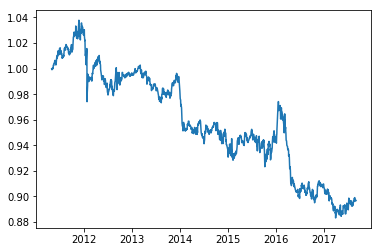

In [20]:
aggregate = [1]
for i in portfolio_daily_returns['portfolio_return']:
    aggregate.append(aggregate[-1]*(i+1))
aggregate = aggregate[1:]
plt.plot(portfolio_daily_returns['date'],aggregate)

In [21]:
portfolio_daily_returns = portfolio_daily_returns.set_index(portfolio_daily_returns['date'])

## 3. output

In [22]:
def mean_return(returns):
    return 252*np.mean(returns)*100
    
def vol(returns):
    return np.sqrt(252)*np.std(returns)*100

def sharpe_ratio(returns):
    return np.sqrt(252)*np.mean(returns)/np.std(returns)

def Sortino(returns):
    return np.sqrt(252)*np.mean(returns)/np.std(returns[returns<0])

def draw_down(returns):
    # We are going to use a trailing 252 trading day window
    window = 252
    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    #Roll_Max = pd.rolling_max(returns, window, min_periods=1)
    
    Roll_Max = returns.rolling(window,min_periods = 1).max()
    Daily_Drawdown = returns/Roll_Max - 1.0

    # Then we calculate the minimum daily drawdown, which is equivalent to maximum drawdown 
    # Again, use min_periods=1 if you want to allow the expanding window
    #Max_Daily_Drawdown = pd.rolling_min(Daily_Drawdown, window, min_periods=1)
    Max_Daily_Drawdown = Daily_Drawdown.rolling(window,min_periods = 1).min()
    return Max_Daily_Drawdown
    
    

In [23]:
for year in range(2011,2017):
    returns = portfolio_daily_returns[str(year)+'-01-01':str(year+1)+'-01-01']['portfolio_return']
    #print(len(returns))
    print(draw_down(returns)[-1])
    print('year %4d, mean return = %.4f, Volatility = %.4f, sharpe ratio = %.4f, Max_Drawdown Rate = %.4f, Sortino ratio = %.4f' % \
          (year,mean_return(returns),vol(returns),sharpe_ratio(returns),draw_down(returns)[-1],Sortino(returns)))

-2.834833678905254
year 2011, mean return = 3.9743, Volatility = 3.0336, sharpe ratio = 1.3101, Max_Drawdown Rate = -2.8348, Sortino ratio = 1.8036
-5.137023069977728
year 2012, mean return = -2.9088, Volatility = 4.8060, sharpe ratio = -0.6052, Max_Drawdown Rate = -5.1370, Sortino ratio = -0.5590
-2.6464163673532695
year 2013, mean return = -1.3883, Volatility = 2.3595, sharpe ratio = -0.5884, Max_Drawdown Rate = -2.6464, Sortino ratio = -0.8133
-3.711991708673401
year 2014, mean return = -4.7674, Volatility = 3.1045, sharpe ratio = -1.5356, Max_Drawdown Rate = -3.7120, Sortino ratio = -2.1073
-2.0567101856418386
year 2015, mean return = 0.8759, Volatility = 4.0126, sharpe ratio = 0.2183, Max_Drawdown Rate = -2.0567, Sortino ratio = 0.3180
-1.7248052069477238
year 2016, mean return = -3.9116, Volatility = 3.6035, sharpe ratio = -1.0855, Max_Drawdown Rate = -1.7248, Sortino ratio = -1.8517


total portfolio return

In [24]:
aggregate[-1]-1

-0.10306895463614574